In [1]:
# Importing the required Libraries
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import glob
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Training Set"
valid_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Validation Set"
test_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set"

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
# Augmenting training data for more training examples
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9500 images belonging to 10 classes.


In [5]:
validation_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 7000 images belonging to 10 classes.


In [6]:
eb3_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= (224,224,3), pooling= 'max')


43950080/43941136 [==============================] - 0s 0us/step


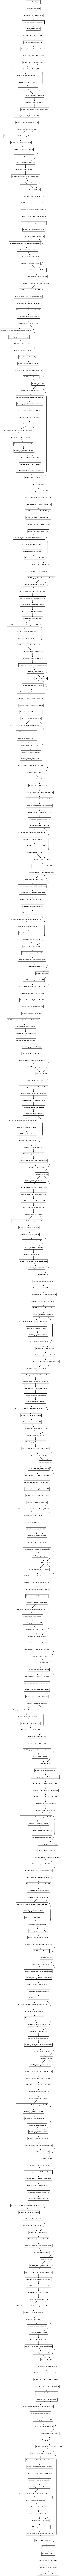

In [7]:
plot_model(eb3_model)

In [8]:
eb3_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [9]:
eb3model = Sequential()
eb3model.add(eb3_model)
eb3model.add(Dense(10, activation="softmax"))
eb3model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
Total params: 10,798,905
Trainable params: 10,711,602
Non-trainable params: 87,303
_________________________________________________________________


In [10]:
eb3model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [11]:
model_save = ModelCheckpoint('./EffB3.h5', 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)
model = eb3model.fit(x = training_set, validation_data=validation_set, epochs=20, callbacks = [model_save, early_stop, reduce_lr])

Epoch 1/20
297/297 [==============================] - 290s 897ms/step - loss: 0.6153 - accuracy: 0.8488 - val_loss: 3.3007 - val_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 3.30070, saving model to ./EffB3.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
297/297 [==============================] - 215s 724ms/step - loss: 0.1628 - accuracy: 0.9474 - val_loss: 2.9670 - val_accuracy: 0.1000

Epoch 00002: val_loss improved from 3.30070 to 2.96701, saving model to ./EffB3.h5
Epoch 3/20
297/297 [==============================] - 215s 722ms/step - loss: 0.1250 - accuracy: 0.9607 - val_loss: 4.4026 - val_accuracy: 0.0760

Epoch 00003: val_loss did not improve from 2.96701
Epoch 4/20
297/297 [==============================] - 215s 721ms/step - loss: 0.1055 - accuracy: 0.9668 - val_loss: 214.8232 - val_accuracy: 0.1070

Epoch 00004: val_loss did not improve from 2.96701

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
297/297 [==============================] - 215s 722ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 4.9748 - val_accuracy: 0.2636

Epoch 00005: val_loss did not improve from 2.96701
Epoch 6/20
297/297 [==============================] - 216s 725ms/step - loss: 0.0218 - accura

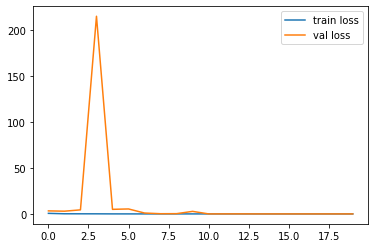

In [12]:
# Loss Plot
plt.plot(model.history['loss'], label='train loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

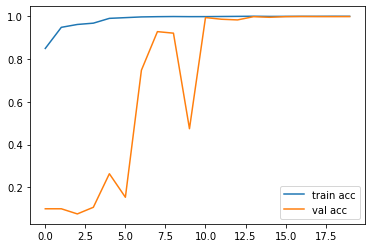

In [13]:
# accuracy plot
plt.plot(model.history['accuracy'], label='train acc')
plt.plot(model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
print("training_accuracy", model.history['accuracy'][-1])
print("validation_accuracy", model.history['val_accuracy'][-1])

training_accuracy 0.9988421201705933
validation_accuracy 0.9977142810821533


In [15]:
test_set = test_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set",
                                            target_size = (224, 224),
                                            batch_size = 450,
                                            class_mode = 'categorical')

Found 500 images belonging to 10 classes.


In [16]:
test_data, test_labels = test_set.next()

In [17]:
test_scores = eb3model.evaluate(test_data, test_labels)
print("Test Accuracy: ",(test_scores[1]))

15/15 [==============================] - 4s 154ms/step - loss: 0.0251 - accuracy: 0.9889
Test Accuracy:  0.9888888597488403


In [18]:
y_pred_test=eb3model.predict(test_data).argmax(axis=1)
print(y_pred_test)

[8 9 1 4 7 8 1 1 6 5 3 0 8 1 6 0 2 4 2 7 1 8 6 5 7 6 4 1 5 6 1 9 0 2 0 5 7
 3 8 8 3 5 1 2 0 9 8 2 9 6 0 7 9 2 8 0 9 0 3 1 5 5 7 5 6 9 2 4 6 9 9 6 3 4
 6 9 1 6 9 9 5 9 6 7 7 6 8 1 1 3 8 3 1 0 3 5 0 0 8 9 2 8 4 8 3 2 0 5 3 4 4
 3 2 6 8 7 1 6 8 4 6 6 4 4 4 6 4 3 0 7 6 6 8 5 3 9 7 9 7 8 7 4 8 2 1 1 4 8
 0 3 0 1 2 1 6 7 3 9 4 6 2 1 5 8 5 7 2 8 7 4 5 3 0 9 5 0 6 2 0 7 4 5 1 2 9
 4 7 6 6 8 9 1 2 5 0 0 1 9 5 5 8 4 7 0 6 9 7 2 2 9 2 6 7 4 1 4 5 8 3 3 7 7
 6 9 4 6 9 1 5 9 2 4 4 7 5 7 5 3 8 6 1 1 5 7 8 5 6 2 5 1 4 0 8 9 1 6 1 0 9
 5 8 0 4 3 9 5 5 2 0 4 3 3 8 5 3 9 1 3 7 9 1 2 0 6 7 9 4 5 6 9 2 7 2 5 2 5
 2 9 6 3 1 8 7 8 7 7 7 2 2 4 9 9 0 1 9 6 3 0 7 6 6 0 9 9 5 1 4 6 8 7 2 9 0
 9 9 3 7 4 0 3 1 8 4 6 6 3 7 9 8 1 6 4 0 2 8 1 3 6 0 5 5 5 8 5 7 7 2 3 0 4
 4 4 0 2 2 0 4 8 1 7 5 1 1 8 2 3 0 3 3 8 7 2 6 2 4 9 8 1 8 7 7 3 3 7 4 2 3
 6 3 0 1 7 2 9 3 8 3 8 4 9 1 3 2 2 3 4 1 0 3 9 3 0 8 1 1 1 5 2 0 2 3 2 2 6
 8 5 3 2 9 4]


In [19]:
#Predicting the test data

pred_labels = eb3model.predict(test_data)
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.98      0.96      0.97        48
           2       0.98      0.98      0.98        47
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00        43
           5       1.00      0.98      0.99        43
           6       0.96      1.00      0.98        44
           7       1.00      1.00      1.00        45
           8       1.00      1.00      1.00        45
           9       1.00      1.00      1.00        48

   micro avg       0.99      0.99      0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450
 samples avg       0.99      0.99      0.99       450



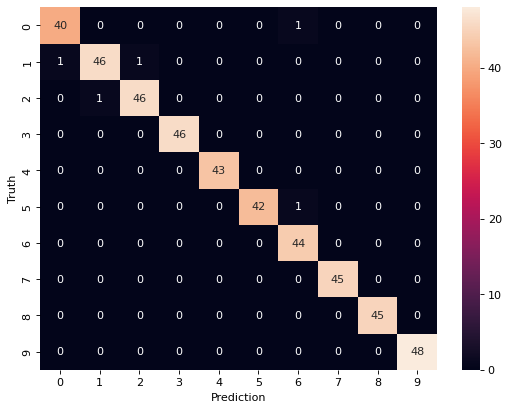

In [20]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# model = load_model("my_best_model.hdf5")
img = image.load_img('/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set/Tomato___healthy/image (1000).JPG', target_size=(224,224))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
classes = eb3model.predict(x)
print (classes)
# predicting images
#image = image.convert("RGB")
result = np.argmax(classes)
dic=dict(training_set.class_indices)
print([key for key in dic.keys()][result]) 

[[1.4102390e-12 8.5315920e-15 4.8853635e-13 1.8246818e-16 5.5345904e-15
  7.1184115e-15 4.7591163e-12 9.0117285e-14 1.3176581e-15 1.0000000e+00]]
Tomato___healthy
